### **Notebook on predicting match outcomes of League of Legends matches at the 15-minute mark**
<br>The aim of this project is to predict which team wins based on in-game values at the 15-minute mark.

Importing all of the packages:

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import time
import logging
import csv
import seaborn as sns
import numpy as np
import os
import tensorflow as tf
import pandas as pd
import re
from concurrent.futures import ThreadPoolExecutor, as_completed
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.regularizers import L1, L2
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV




#### **Step 1: Acquiring the data**
<br>There are two ways for me to acquire the data that I will be using for this project:
- Using pre-made data
- Getting the data myself

While pre-made data will save me a lot of time, since League of Legends changes a lot within a short amount of time, these datasets could be outdated.
<br> This is why I will be gathering the data myself using the Riot Games API.

*Step 1.5: Workflow for the Riot API*
<br>In order to read match data, I will first need to get a player's PUUID (Player Universally Unique Identifier). This is a unique and consistent identifier across regions, nations and games for every player.
<br>Using this ID I can read a player's match history, which gives me the ID's for the matches that have been played.
<br>From these matches I can extract the relevant features that I need to predict the match outcome at the 15-minute mark. 
<br>
<br>The access rates for the API are the following:
- 20 requests every 1 seconds(s)
- 100 requests every 2 minutes(s) 

The API key is only valid for 24 hours. This means I should be able to extract around 72,000 matches that I can use to train the model.  

The following graph represents the League of Legends rank distribution in my home region, EU West (EUW1), as of January 2025 (source: LeagueOfGraphs): 

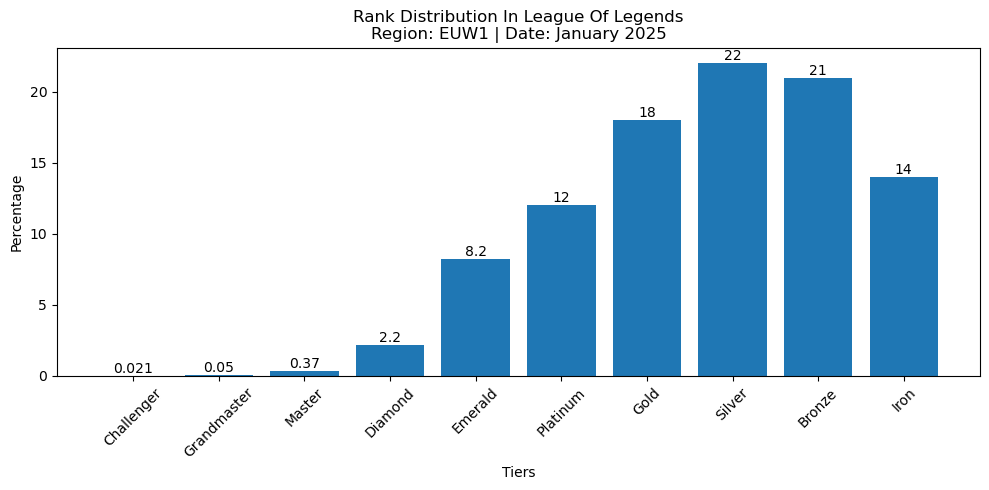

In [ ]:

tiers = ['Challenger', 'Grandmaster', 'Master', 'Diamond', 'Emerald', 'Platinum', 'Gold', 'Silver', 'Bronze', 'Iron']
percentage = [0.021, 0.05, 0.37, 2.2, 8.2, 12, 18, 22, 21, 14]

fig = plt.figure(figsize=(10, 5))
plt.bar(tiers, percentage)
for i in range(len(percentage)):
    plt.annotate(str(percentage[i]), xy=(tiers[i], percentage[i]), ha='center', va='bottom')
plt.xlabel("Tiers")
plt.ylabel("Percentage")
plt.title('Rank Distribution In League Of Legends\nRegion: EUW1 | Date: January 2025')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This means the dataset should consist of the following amount of games per rank: <br>
| **Rank** | Challenger | Grandmaster | Master | Diamond | Emerald | Platinum | Gold | Silver | Bronze | Iron | **Total** |
| ------ | ------ | ------ | ------ | ------ | ------ | ------ | ------ | ------ | ------ | ------ | ------ |
| **Percentage (%)** | 1 | 1 | 1 | 2 | 8 | 12 | 18 | 22 | 21 | 14 | **100** |

The Riot Games Match History endpoint has a maximum of 100 matches per player, which means that I have to make sure that I get both enough matches per rank, and enough players to not exceed the 100-match cap.
<br>After doing some calculations this is what the distribution of games and players will look like: <br>
| **Rank** | Challenger | Grandmaster | Master | Diamond | Emerald | Platinum | Gold | Silver | Bronze | Iron | **Total** |
| ------ | ------ | ------ | ------ | ------ | ------ | ------ | ------ | ------ | ------ | ------ | ------ |
| **Players tracked** | 7 | 7 | 7 | 15 | 57 | 84 | 126 | 154 | 147 | 98 | **702** |
| **Games tracked** | 700 | 700 | 700 | 1500 | 5700 | 8400 | 12600 | 15400 | 14700 | 9800 | **70200** |

*Note: I'm using slightly less than 72,000 games, but this should not be a problem since the dataset is still big enough*  

Below is the final graph which shows the amount of games tracked per rank:

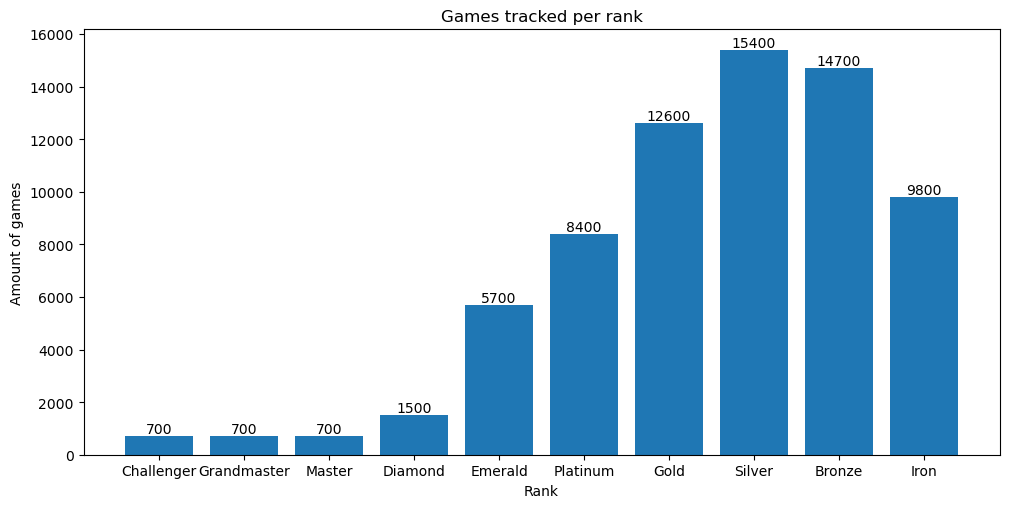

In [5]:
tiers = ['Challenger', 'Grandmaster', 'Master', 'Diamond', 'Emerald', 'Platinum', 'Gold', 'Silver', 'Bronze', 'Iron']
percentage = [700, 700, 700, 1500, 5700, 8400, 12600, 15400, 14700, 9800]

fig = plt.figure(figsize=(10, 5))
plt.bar(tiers, percentage)
for i in range(len(percentage)):
    plt.annotate(str(percentage[i]), xy=(tiers[i], percentage[i]), ha='center', va='bottom')
plt.xlabel('Rank')
plt.tight_layout()
plt.ylabel('Amount of games')
plt.title('Games tracked per rank')
plt.show()

#### Retrieving the match data

The next step is retrieving the data using the Riot API. I will retrieve the Summoner's ID (player name) and derive the PUUID from that, and then retrieve the match history and specific games. 

<br>While this is a safety hazard from a cybersecurity perspective, I'm putting my API key below so that I can easily change it.

In [2]:
api_key = 'RGAPI-2089c854-fc7a-460e-8f52-a9377df3d508'

First, I gather the summoner ID's using the following script, and I will save them in a separate file to use them later.

In [ ]:
def apex(elo, amount):
    gathered = 0
    summoner_ids = []

    while gathered < amount:
        response = requests.get(
            f'https://euw1.api.riotgames.com/lol/league/v4/{elo}leagues/by-queue/RANKED_SOLO_5x5?api_key={api_key}')
        response_data = response.json()

        if 'entries' not in response_data:
            print("error: 'entries' key not found in the response")
            return

        for summoner in response_data['entries']:
            try:
                summoner_ids.append(summoner['summonerId'])
                gathered += 1
                print(f'summoner id: {summoner["summonerId"]}')
                if gathered >= amount:
                    break
            except UnicodeEncodeError:
                pass

    print(f'gathered {gathered} {elo} players')

    with open('summonerIds.txt', 'a') as f:
        for summoner_id in summoner_ids:
            f.write(summoner_id + '\n')


def casuals(elo, amount, page=1):
    gathered = 0
    summoner_ids = []

    while gathered < amount:
        response = requests.get(
            f'https://euw1.api.riotgames.com/lol/league/v4/entries/RANKED_SOLO_5x5/{elo}/III?page={page}&api_key={api_key}')

        for summoner in response.json():
            try:
                summoner_ids.append(summoner['summonerId'])
                gathered += 1
                print(f'summoner id: {summoner["summonerId"]}')
                if gathered >= amount:
                    break
            except UnicodeEncodeError:
                pass
        page += 1

    print(f'gathered {gathered} {elo} players')

    with open('summonerIds.txt', 'a') as f:
        for summoner_id in summoner_ids:
            f.write(summoner_id + '\n')


if __name__ == '__main__':
    t = time.time()
    apex('challenger', 7)
    apex('grandmaster', 7)
    apex('master', 7)
    casuals('DIAMOND', 15)
    casuals('EMERALD', 57)
    casuals('PLATINUM', 84)
    casuals('GOLD', 126)
    casuals('SILVER', 154)
    casuals('BRONZE', 147)
    casuals('IRON', 98)
    print(f'\ntook {round(time.time() - t, 2)} seconds')


summoner id: l1DcSsw46lxcgv5n-ngWScBA40iLn4E3hfySNHZIrop2ANg
summoner id: 1kj6FDYFpu8-GBUrf3eR0gbM6pIg2YOiZiIuVv0HEgjQLFA
summoner id: -dR4wwMFSOHRTTiCiEiZrF7GXNYw3WhOtbTG7Bd_3a5sgxO-
summoner id: J6nqtTXizVw8-L6FvHGKDLe29TwUgIOpi3AxTajeStVt_PU
summoner id: 5hGHNumAJc-A3j0Z4zyk7QalIrgdLwswrQlrMT-PBU7AcIY
summoner id: zp_7AIZq89YSVGep6lMUNjYF2Vsfpd2WPTNB8XNblvh2s5s
summoner id: qIhjX-nKdCP87sdB10zoX0e2uI-JRc1merDQeJstWkZ3wskb
gathered 7 challenger players
summoner id: MJCf5p2qRMfrN8HbYxVHsbFUVLalw1UL6eG9bQG8j6QISZb3UIsyKSXXYQ
summoner id: PdLXPHMs1-ehTYWBORS6xgrGXr-xqNIsuZgvkBJJ3SEa7kY
summoner id: KuRaZ00v7GrjpI3qcjCyVvoOKzPhNeSVYzquJXABJy90dkYF
summoner id: hZ1FuXRJwuxK86boYpXPQecjLV2LSOwuiNHdI66U9-rZXhA
summoner id: l97skUj_LHbwaRijstaQhWQ4yi75wuzE1zuzOg3CLIcYmBE
summoner id: 6fPgwsbOLkS5SWrkkMr_xTkVkFiybmnCMUeEdr1SqBZP1APpRCimQL0uZw
summoner id: eQuPBUYdujNIeeZzxjUkfCZa7gxbv8OQlTYUdhJr6jwPATY
gathered 7 grandmaster players
summoner id: rAbzYmsVIRBHx5Nd002dYbkBBIczFPeWZPkkrTkJjVs8G8c

Next, I derive the PUUID's from the Summoner ID's:

In [ ]:
def fetch_puuid(summoner_id):
    global api_key  # Access the API key from the global scope
    url = f"https://euw1.api.riotgames.com/lol/summoner/v4/summoners/{summoner_id}?api_key={api_key}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        return data.get('puuid')
    else:
        print(f"failed to fetch data for {summoner_id}, status code: {response.status_code}")
        return None

def main():
    # Initial delay to ensure rate limits are respected if other scripts were run recently
    initial_delay = 120  # 2 minutes in seconds
    print(f"Applying initial delay of {initial_delay} seconds to respect rate limits.")
    time.sleep(initial_delay)

    with open('summonerIds.txt', 'r') as f:
        summoner_ids = f.read().splitlines()

    puuids = []
    batch_size = 20  # Adjusted to match short-term rate limit
    delay = 1  # Delay to meet 20 requests/second limit

    # Variables for long-term rate limiting
    long_term_limit = 100  # Maximum requests in 2 minutes
    long_term_window = 121  # 2 minutes and 1 second in seconds
    requests_made = 0
    start_time = time.time()

    for i in range(0, len(summoner_ids), batch_size):
        batch = summoner_ids[i:i + batch_size]

        with ThreadPoolExecutor(max_workers=batch_size) as executor:
            futures = [executor.submit(fetch_puuid, summoner_id) for summoner_id in batch]
            for future in futures:
                puuid = future.result()
                if puuid:
                    puuids.append(puuid)
        
        # Increment requests counter
        requests_made += len(batch)

        # Print progress after processing each batch
        print(f"processed {len(puuids)} summoner ids")

        # Enforce long-term rate limit
        elapsed_time = time.time() - start_time
        if requests_made >= long_term_limit:
            if elapsed_time < long_term_window:
                sleep_time = long_term_window - elapsed_time
                print(f"Reached 100 requests. Pausing for {sleep_time:.2f} seconds to respect long-term rate limit.")
                time.sleep(sleep_time)
            # Reset counter and timer for the next window
            requests_made = 0
            start_time = time.time()

        # Short-term rate limit enforcement
        time.sleep(delay)  # Ensure we stay under the 20 requests/second limit

    with open('puuids.txt', 'a') as f:
        for puuid in puuids:
            f.write(puuid + '\n')

if __name__ == "__main__":
    t = time.time()
    main()
    print(f"took {round(time.time() - t, 2)} seconds")


Applying initial delay of 120 seconds to respect rate limits.
processed 20 summoner ids
processed 40 summoner ids
processed 60 summoner ids
processed 80 summoner ids
processed 100 summoner ids
Reached 100 requests. Pausing for 114.98 seconds to respect long-term rate limit.
processed 120 summoner ids
processed 140 summoner ids
processed 160 summoner ids
processed 180 summoner ids
processed 200 summoner ids
Reached 100 requests. Pausing for 113.79 seconds to respect long-term rate limit.
failed to fetch data for Eov9O9HUvfn4Zz39G87G1gHuE22KHacqGPLB3ES7EwZuhizG, status code: 429
failed to fetch data for w680fjMnSUEFtsHEOQeshWDZxBgQJDTdknE3kaU9ppRQtV4U, status code: 429
failed to fetch data for L0nlL_uMZ0wBJDJyzIXUoS14hlCd24s6cqw0xGNecRvszX7X, status code: 429
failed to fetch data for AKiIiYzwJ32H9JCrrcWmo2g0YY7mv1iyNOm_0bHJxOthep-i, status code: 429
failed to fetch data for eH-acWT4Fo7eEXMvNC8tYiFLQMyA9AKYHtciCTofka4d3zjE, status code: 429
failed to fetch data for LSawMfTpRx-G86BFyPBzy3j

With the PUUID's, I can retrieve match ID's:    

In [9]:
def fetch_games(puuid):
    global api_key  # Access the API key from the global scope
    url = f"https://europe.api.riotgames.com/lol/match/v5/matches/by-puuid/{puuid}/ids?queue=420&type=ranked&start=0&count=100&api_key={api_key}"
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"failed to fetch data for {puuid}, status code: {response.status_code}")
        return None

def main():
    # Initial delay to respect rate limits if other scripts were run recently
    initial_delay = 120  # 2 minutes in seconds
    print(f"Applying initial delay of {initial_delay} seconds to respect rate limits.")
    time.sleep(initial_delay)

    with open('puuids.txt', 'r') as f:
        summoner_ids = f.read().splitlines()

    game_list = []
    batch_size = 20  # Reduced batch size to comply with 20 requests/second limit
    delay = 1  # Short-term delay between batches

    # Variables for long-term rate limiting
    long_term_limit = 100  # Maximum requests in 2 minutes
    long_term_window = 121  # 2 minutes in seconds
    requests_made = 0
    start_time = time.time()

    for i in range(0, len(summoner_ids), batch_size):
        batch = summoner_ids[i:i + batch_size]

        with ThreadPoolExecutor(max_workers=batch_size) as executor:
            futures = [executor.submit(fetch_games, puuid) for puuid in batch]
            for future in futures:
                games = future.result()
                if games:
                    game_list.extend(games)  # Extend to avoid nested lists

        # Increment requests counter
        requests_made += len(batch)

        # Print progress
        print(f"processed {len(game_list)} match IDs")

        # Enforce long-term rate limit
        elapsed_time = time.time() - start_time
        if requests_made >= long_term_limit:
            if elapsed_time < long_term_window:
                sleep_time = long_term_window - elapsed_time
                print(f"Reached 100 requests. Pausing for {sleep_time:.2f} seconds to respect long-term rate limit.")
                time.sleep(sleep_time)
            # Reset counter and timer for the next window
            requests_made = 0
            start_time = time.time()

        # Short-term rate limit enforcement
        time.sleep(delay)  # Ensure we stay under the 20 requests/second limit

    with open('matchIds.txt', 'a') as f:
        for match_id in game_list:
            f.write(match_id + '\n')

if __name__ == "__main__":
    t = time.time()
    main()
    print(f"took {round(time.time() - t, 2)} seconds")


Applying initial delay of 120 seconds to respect rate limits.
processed 2000 match IDs
processed 3930 match IDs
processed 5814 match IDs
processed 7754 match IDs
processed 9648 match IDs
Reached 100 requests. Pausing for 115.77 seconds to respect long-term rate limit.
processed 11480 match IDs
processed 13220 match IDs
processed 15212 match IDs
processed 17177 match IDs
processed 18963 match IDs
Reached 100 requests. Pausing for 114.99 seconds to respect long-term rate limit.
processed 20867 match IDs
processed 22633 match IDs
processed 24403 match IDs
processed 26170 match IDs
processed 27761 match IDs
Reached 100 requests. Pausing for 114.95 seconds to respect long-term rate limit.
processed 29483 match IDs
processed 31163 match IDs
processed 32910 match IDs
processed 34584 match IDs
processed 36332 match IDs
Reached 100 requests. Pausing for 115.03 seconds to respect long-term rate limit.
processed 38124 match IDs
processed 39802 match IDs
processed 41557 match IDs
processed 43054 m

From the match ID's I can now derive the match data:

In [3]:
def fetch_match_data(match_id):
    global api_key  # Ensure API key is global
    url = f'https://europe.api.riotgames.com/lol/match/v5/matches/{match_id}/timeline?api_key={api_key}'
    try:
        response = requests.get(url, timeout=10)
        if response.status_code == 200:
            data = response.json()
            if 'info' not in data or 'frames' not in data['info']:
                return None
            return data  # Process as required
        else:
            print(f"Failed to fetch data for match {match_id}, status code: {response.status_code}")
            return None
    except Exception as e:
        print(f"Error fetching data for match {match_id}: {e}")
        return None


def main():
    with open('matchIds.txt', 'r') as f:
        matches = f.read().splitlines()

    with open('match-data.csv', 'a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['winningTeam', 'blueTeamWardsPlaced', 'blueTeamKills', 'blueTeamTotalJungleMinionsKilled',
                         'blueTeamTotalMinionsKilled', 'blueTeamAvgLevel', 'blueTeamCsPerMinute',
                         'blueTeamGoldPerMinute', 'redTeamWardsDestroyed', 'redTeamKills',
                         'redTeamTotalJungleMinionsKilled', 'redTeamTotalMinionsKilled',
                         'redTeamAvgLevel', 'redTeamCsPerMinute', 'redTeamGoldPerMinute'])

        batch_size = 20  # Adjusted for 20 requests/second limit
        delay = 1  # Delay between batches for short-term compliance
        long_term_limit = 100  # Maximum requests in 2 minutes
        long_term_window = 121  # 2 minutes in seconds
        requests_made = 0
        start_time = time.time()

        for i in range(0, len(matches), batch_size):
            batch = matches[i:i + batch_size]

            with ThreadPoolExecutor(max_workers=batch_size) as executor:
                futures = [executor.submit(fetch_match_data, match_id) for match_id in batch]
                for future in as_completed(futures):
                    result = future.result()
                    if result:
                        writer.writerow(result)

            # Increment request count
            requests_made += len(batch)
            elapsed_time = time.time() - start_time

            # Enforce long-term rate limit
            if requests_made >= long_term_limit:
                if elapsed_time < long_term_window:
                    sleep_time = long_term_window - elapsed_time
                    print(f"Reached 100 requests. Pausing for {sleep_time:.2f} seconds to respect long-term rate limit.")
                    time.sleep(sleep_time)
                requests_made = 0
                start_time = time.time()

            # Enforce short-term rate limit
            time.sleep(delay)

            print(f"Processed {i + len(batch)} matches.")

if __name__ == '__main__':
    t = time.time()
    main()
    print(f"Took {round(time.time() - t, 2)} seconds.")


Error fetching data for match EUW1_7232608427: HTTPSConnectionPool(host='europe.api.riotgames.com', port=443): Max retries exceeded with url: /lol/match/v5/matches/EUW1_7232608427/timeline?api_key=RGAPI-2089c854-fc7a-460e-8f52-a9377df3d508 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x0000016C7E223B00>, 'Connection to europe.api.riotgames.com timed out. (connect timeout=10)'))Error fetching data for match EUW1_7234038609: HTTPSConnectionPool(host='europe.api.riotgames.com', port=443): Max retries exceeded with url: /lol/match/v5/matches/EUW1_7234038609/timeline?api_key=RGAPI-2089c854-fc7a-460e-8f52-a9377df3d508 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x0000016C7E222900>, 'Connection to europe.api.riotgames.com timed out. (connect timeout=10)'))
Error fetching data for match EUW1_7249728255: HTTPSConnectionPool(host='europe.api.riotgames.com', port=443): Max retries exceeded with url: /lol/match/v5/matches/EUW1_724972

KeyboardInterrupt: 

#### Step 2: Data exploration and cleaning
Now that I have my raw match data, I will explore and clean the dataset so that I can use it to train a model. 
<br>First, I will load the dataset and display some basic information and statistics about it.

In [23]:
df = pd.read_csv('match-data.csv')
df.head()

,winningTeam,blueTeamWardsPlaced,blueTeamKills,blueTeamTotalJungleMinionsKilled,blueTeamTotalMinionsKilled,blueTeamAvgLevel,blueTeamCsPerMinute,blueTeamGoldPerMinute,redTeamWardsDestroyed,redTeamKills,redTeamTotalJungleMinionsKilled,redTeamTotalMinionsKilled,redTeamAvgLevel,redTeamCsPerMinute,redTeamGoldPerMinute
0,1,35,14,66.4,248.3,8.32,20.98,1454.07,2,7,77.8,232.1,8.10,20.66,1269.97
1,0,35,14,85.7,273.3,8.68,23.93,1469.90,12,9,76.5,292.2,8.56,24.58,1433.52
2,0,29,11,74.5,276.1,8.60,23.37,1427.19,4,10,83.6,278.7,8.60,24.15,1403.89
3,1,36,7,74.4,278.6,8.58,23.53,1339.34,5,6,79.0,307.0,8.76,25.73,1366.71
4,0,57,5,84.2,235.7,8.36,21.33,1293.19,8,15,81.1,263.2,8.84,22.95,1517.49


Below is a dataframe that display minimum, maximum and mean values for all the features that I will need.

In [24]:
column_names = [
    "winningTeam", "blueTeamWardsPlaced", "blueTeamKills",
    "blueTeamTotalJungleMinionsKilled", "blueTeamTotalMinionsKilled",
    "blueTeamAvgLevel", "blueTeamCsPerMinute", "blueTeamGoldPerMinute",
    "redTeamWardsDestroyed", "redTeamKills",
    "redTeamTotalJungleMinionsKilled", "redTeamTotalMinionsKilled",
    "redTeamAvgLevel", "redTeamCsPerMinute", "redTeamGoldPerMinute"
]

# Filter DataFrame for these columns
df = df[column_names]

# Calculate statistics
statistics = {
    "Column name": [],
    "Minimum": [],
    "Maximum": [],
    "Mean": []
}

for col in column_names:
    statistics["Column name"].append(col)
    statistics["Minimum"].append(round(df[col].min(), 2))  # Round to 2 decimals
    statistics["Maximum"].append(round(df[col].max(), 2))  # Round to 2 decimals
    statistics["Mean"].append(round(df[col].mean(), 2))  # Round to 2 decimals
    
# Create DataFrame for results
statistics_df = pd.DataFrame(statistics)

# Display the result
print(statistics_df)

                         Column name  Minimum  Maximum     Mean
0                        winningTeam     0.00     1.00     0.52
1                blueTeamWardsPlaced     6.00   644.00    53.60
2                      blueTeamKills     0.00    31.00    11.69
3   blueTeamTotalJungleMinionsKilled     0.00   106.80    65.81
4         blueTeamTotalMinionsKilled    72.80   319.80   240.43
5                   blueTeamAvgLevel     5.98     9.44     8.48
6                blueTeamCsPerMinute     5.79    26.36    20.42
7              blueTeamGoldPerMinute   862.84  1888.92  1357.16
8              redTeamWardsDestroyed     0.00    44.00     5.47
9                       redTeamKills     0.00    27.00    11.34
10   redTeamTotalJungleMinionsKilled     0.00   101.10    65.79
11         redTeamTotalMinionsKilled   148.70   320.30   239.83
12                   redTeamAvgLevel     7.46     9.30     8.46
13                redTeamCsPerMinute    13.07    26.97    20.37
14              redTeamGoldPerMinute  10

The maximum value for blueTeamWardsPlaced is unusually high, so I'm going to take a look if this is a common occurence or an exception.

In [ ]:
print('800+', df[df['blueTeamWardsPlaced'] > 800].shape[0])
print('700-800', df[(df['blueTeamWardsPlaced'] > 700) & (df['blueTeamWardsPlaced'] <= 800)].shape[0])
print('600-700', df[(df['blueTeamWardsPlaced'] > 600) & (df['blueTeamWardsPlaced'] <= 700)].shape[0])
print('500-600', df[(df['blueTeamWardsPlaced'] > 500) & (df['blueTeamWardsPlaced'] <= 600)].shape[0])
print('400-500', df[(df['blueTeamWardsPlaced'] > 400) & (df['blueTeamWardsPlaced'] <= 500)].shape[0])
print('300-400', df[(df['blueTeamWardsPlaced'] > 300) & (df['blueTeamWardsPlaced'] <= 400)].shape[0])
print('200-300', df[(df['blueTeamWardsPlaced'] > 200) & (df['blueTeamWardsPlaced'] <= 300)].shape[0])
print('100-200', df[(df['blueTeamWardsPlaced'] > 100) & (df['blueTeamWardsPlaced'] <= 200)].shape[0])
print('0-100', df[df['blueTeamWardsPlaced'] <= 100].shape[0])  


800+ 0
700-800 0
600-700 1
500-600 1
400-500 17
300-400 46
200-300 96
100-200 156
0-100 2485


Judging from these numbers it's most likely an exception, so no further action is needed. The rest of the data is also looking good.
<br> Below is a graph that shows the winrate for both teams: 

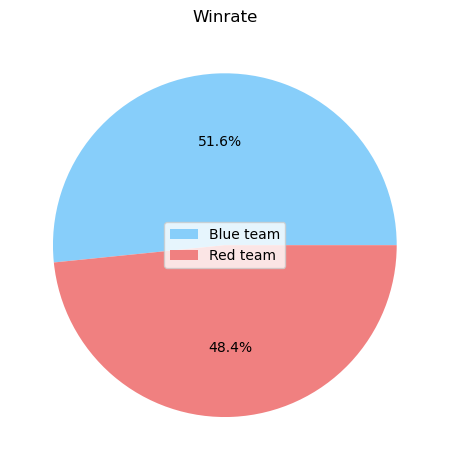

In [14]:
wt = df['winningTeam']
bw = np.sum(wt == 1)
rw = np.sum(wt == 0)

plt.pie([bw, rw], autopct='%1.1f%%', colors=['lightskyblue', 'lightcoral'])
plt.legend(['Blue team', 'Red team'], loc='center')
plt.title('Winrate')
plt.tight_layout()

plt.show()

The current winrate for the blue team on EUW is 51.4 % (LeagueOfGraphs). My data is only slightly off, which is reasonable.

#### Step 3: Feature engineering
Now, I will add the following features to the model that I'm going to be using to simplify my model for learning. <br>I only need these features for one team, since the red team wins if the blue team does not. <br> So, I will take a look at the values for the blue team.
| Variable                        | Calculation                                                                 |
|---------------------------------|-----------------------------------------------------------------------------|
| blueTeamWardRetentionRatio      | (blueTeamWardsPlaced - redTeamWardsDestroyed) / blueTeamWardsPlaced         |
| blueTeamNetKills                | blueTeamKills - redTeamKills                                                |
| blueTeamJungleMinionsKilledDiff | blueTeamTotalJungleMinionsKilled - redTeamTotalJungleMinionsKilled          |
| blueTeamMinionsKilledDiff       | blueTeamTotalMinionsKilled - redTeamTotalMinionsKilled                      |
| blueTeamAvgLevelDiff            | blueTeamAvgLevel - redTeamAvgLevel                                          |
| blueTeamCsPerMinuteDiff         | blueTeamCsPerMinute - redTeamCsPerMinute                                    |
| blueTeamGoldPerMinuteDiff       | blueTeamGoldPerMinute - redTeamGoldPerMinute                                |


In [25]:
df['blueTeamWardRetentionRatio'] = (df.blueTeamWardsPlaced - df.redTeamWardsDestroyed)/df.blueTeamWardsPlaced
df['blueTeamNetKills'] = (df.blueTeamKills - df.redTeamKills)
df['blueTeamJungleMinionsKilledDiff'] = (df.blueTeamTotalJungleMinionsKilled - df.redTeamTotalJungleMinionsKilled)
df['blueTeamMinionsKilledDiff'] = (df.blueTeamTotalMinionsKilled - df.redTeamTotalMinionsKilled)
df['blueTeamAvgLevelDiff'] = (df.blueTeamAvgLevel - df.redTeamAvgLevel)
df['blueTeamCsPerMinuteDiff'] = (df.blueTeamCsPerMinute - df.redTeamCsPerMinute)
df['blueTeamGoldPerMinuteDiff'] = (df.blueTeamGoldPerMinute - df.redTeamGoldPerMinute)

Before I start building and training a model, it's wise to take a look at the correlations between different features. With this I'm looking for what feature influences another feature the most.
<br>What we are most interested in is what determines which team wins the game.

Below is a heatmap for all the variables on the blue team: 

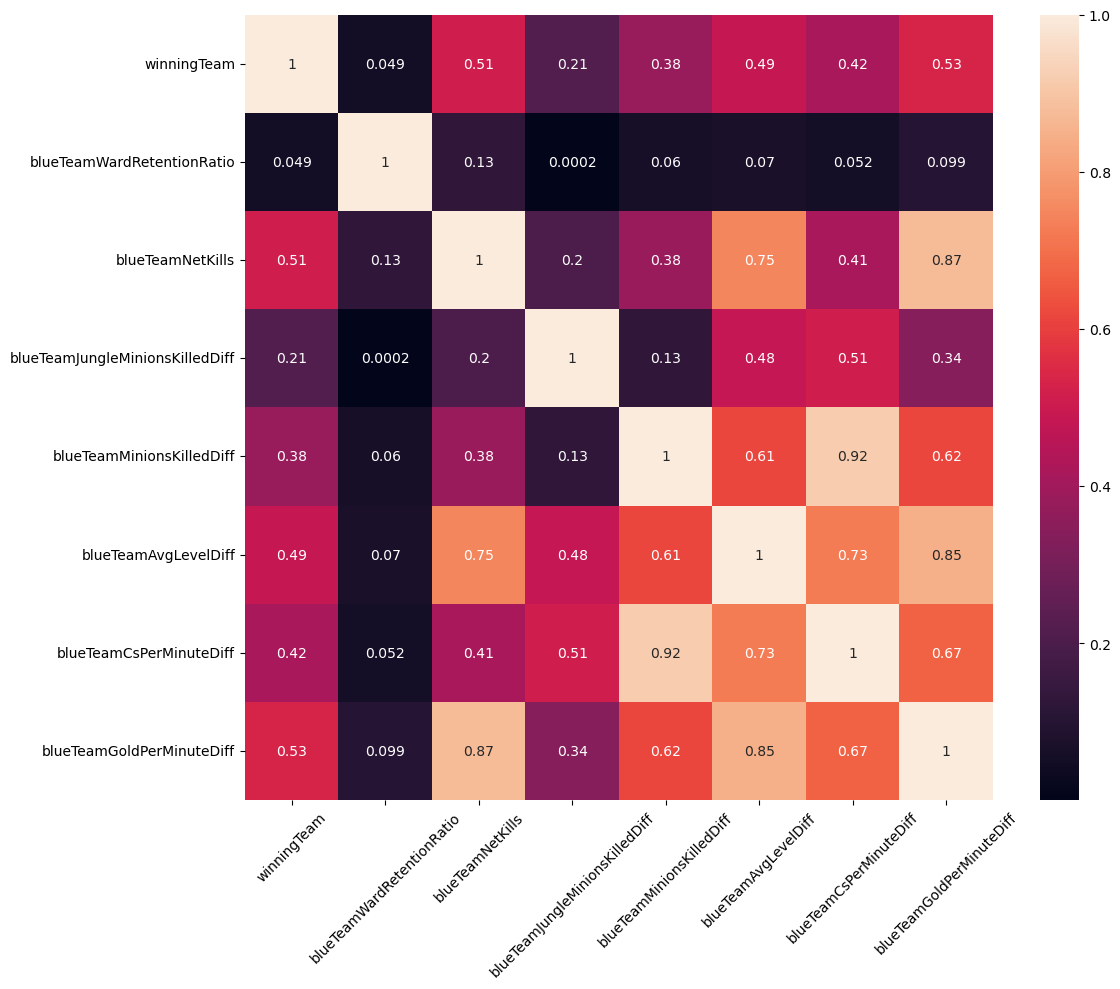

In [ ]:
# remove the columns that are not needed
df = df[['winningTeam', 'blueTeamWardRetentionRatio', 'blueTeamNetKills', 'blueTeamJungleMinionsKilledDiff', 'blueTeamMinionsKilledDiff', 'blueTeamAvgLevelDiff', 'blueTeamCsPerMinuteDiff', 'blueTeamGoldPerMinuteDiff']]

# normalise the data
df.iloc[:, 1:] = (df.iloc[:, 1:] - df.iloc[:, 1:].mean()) / df.iloc[:, 1:].std()

# seaborn plot
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Below is a table which shows the highest and lowest correlation for each feature:
| Feature                         | Highest Correlation With      | Lowest Correlation With          |
|---------------------------------|-------------------------------|----------------------------------|
| winningTeam                     | GoldPerMinute                 | WardRetentionRatio               |
| WardRetentionRatio              | NetKills                      | JungleMinionsKilled              |
| NetKills                        | GoldPerMinute                 | WardRetentionRatio               |
| JungleMinionsKilled             | CsPerMinute                   | WardRetentionRatio               |
| MinionsKilled                   | CsPerMinute                   | WardRetentionRatio               |
| AvgLevel                        | GoldPerMinute                 | WardRetentionRatio               |
| CsPerMinute                     | MinionsKilled                 | WardRetentionRatio               |
| GoldPerMinute                   | NetKills                      | WardRetentionRatio               |


Looking at the heatmap and the table, we can see that `winningTeam` correlates the most with `GoldPerMinute`. Then, `GoldPerMinute` correlates the most with `NetKills`.
<br>As a League of Legends player myself I find this very interesting because most players would agree with me when I say that you need to get good Cs per minute (amount of minions killed) to get a high amount of gold per minute. <br>However, kills do give you 300 gold on average per kill, so if you get a lot of kills you will get a lot of gold (which means your gold per minute will be high).




Now that I have all the data and the relevant features set up, I can start training the model.

#### Step 4: Hyperparameters
Hyperparameters are the settings you choose before training a machine learning model, like the speed of learning or the number of layers in a neural network. 
<br> They guide how the model learns patterns from data but are not adjusted by the model itself during training. 
<br> In order to find the best hyperparameters (i.e. the ones that yield the best result based on the target metric) I will be using a technique called `GridSearch`. 
<br> `GridSearch` is a way to try out all possible combinations of settings for a machine learning model to find the combination that works best.

Below is a table of the different hyperparameters that I will use to conduct the `GridSearch`:
| Optimizer | Activation | Neurons | Batch Size | Epochs |
|-----------|------------|---------|------------|--------|
| adam      | relu       | 16      | 10         | 50     |
| rmsprop   | tanh       | 32      | 20         | 100    |
|           | sigmoid    | 64      | 50         | 150    |
|           |            | 128     |            |        |

I will also use `EarlyStopping` to prevent spending resources on combinations that overlap.
<br>Below is the script to create the model and look for the best hyperparameters:

In [57]:
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'  # suppress onednn

# set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()
fh = logging.FileHandler('grid_search_log.txt')
fh.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
logger.addHandler(fh)

logging.info('loading data...')
df = pd.read_csv('match-data.csv')

# feature engineering
logging.info('getting features...')
df['blueTeamWardRetentionRatio'] = (df.blueTeamWardsPlaced - df.redTeamWardsDestroyed)/df.blueTeamWardsPlaced
df['blueTeamNetKills'] = (df.blueTeamKills - df.redTeamKills).astype(float)
df['blueTeamJungleMinionsKilledDiff'] = (df.blueTeamTotalJungleMinionsKilled - df.redTeamTotalJungleMinionsKilled)
df['blueTeamMinionsKilledDiff'] = (df.blueTeamTotalMinionsKilled - df.redTeamTotalMinionsKilled)
df['blueTeamAvgLevelDiff'] = (df.blueTeamAvgLevel - df.redTeamAvgLevel)
df['blueTeamCsPerMinuteDiff'] = (df.blueTeamCsPerMinute - df.redTeamCsPerMinute)
df['blueTeamGoldPerMinuteDiff'] = (df.blueTeamGoldPerMinute - df.redTeamGoldPerMinute)

# remove the columns that are not needed
df = df[['winningTeam', 'blueTeamWardRetentionRatio', 'blueTeamNetKills', 'blueTeamJungleMinionsKilledDiff',
         'blueTeamMinionsKilledDiff', 'blueTeamAvgLevelDiff', 'blueTeamCsPerMinuteDiff', 'blueTeamGoldPerMinuteDiff']]

# drop NA
df = df.dropna()

# normalize the data except for the target variable 'winningTeam'
logging.info('normalizing data...')
df.iloc[:, 1:] = (df.iloc[:, 1:] - df.iloc[:, 1:].mean()) / df.iloc[:, 1:].std()


# splitting
logging.info('splitting data into training and testing sets...')
X = df.drop('winningTeam', axis=1)
y = df['winningTeam']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0)


# define the model
def create_model(optimizer='adam', activation='relu', neurons=32):
    logging.info(f'creating model with optimizer={optimizer}, activation={activation}, neurons={neurons}')
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    model.add(Dense(neurons, activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model


# get keras classifier, early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
model = KerasClassifier(model=create_model, optimizer='adam', activation='relu', neurons=32, callbacks=[early_stopping], verbose=0)

# randomized search parameters
param_grid = {
    'optimizer': ['adam', 'rmsprop'],
    'activation': ['relu', 'tanh', 'sigmoid'],
    'neurons': [16, 32, 64, 128],
    'batch_size': [10, 20, 50],
    'epochs': [50, 100, 150]
}

# randomized search
logging.info('starting randomized search...')
start = time.time()
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, verbose=3)
search_result = grid_search.fit(X_train, y_train)
end = time.time()
logging.info(f'randomized search completed in {round(end - start, 2)} seconds')

# summarise
logging.info('summarizing results...')
best_score = search_result.best_score_
best_params = search_result.best_params_
means = search_result.cv_results_['mean_test_score']
stds = search_result.cv_results_['std_test_score']
params = search_result.cv_results_['params']

with open('grid_search_results3.txt', 'w') as f:
    f.write(f'best: {best_score} using {best_params}\n')
    for mean, std, param in zip(means, stds, params):
        f.write(f'mean: {mean}, std: {std}, params: {param}\n')
    f.write(f'took: {round(end - start, 2)} seconds\n')

print(f'\nbest: {best_score} using {best_params}')

2025-01-03 01:56:07,848 - INFO - loading data...
2025-01-03 01:56:07,857 - INFO - getting features...
2025-01-03 01:56:07,888 - INFO - normalizing data...
2025-01-03 01:56:07,901 - INFO - splitting data into training and testing sets...
2025-01-03 01:56:07,914 - INFO - starting randomized search...


Fitting 3 folds for each of 216 candidates, totalling 648 fits


c:\Users\User\anaconda3\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


KeyboardInterrupt: 

The best hyperparameters for the set of data I got are:

- activation: sigmoid
- batch_size: 20
- epochs: 150
- neurons: 32
- optimizer: adam

##### Hyperparameter tuning 2: Regularization and number of layers

The next block of code will compare the next set of hyperparameters, these being regularization and the number of layers.
<br>I decided not to run the entire `GridSearch again`, since adding more hyperparameters will increase the amount of models to train exponentially.
<br>Instead, I will run a few more models with different configurations of the missing hyperparameters to see which gives the best result.
<br>These are the hyperparameters:
| Regularisation | Layers |
|----------------|--------|
| L1(0.001)      | 1      |
| L1(0.01)       | 2      |
| L1(0.1)        | 3      |
| L2(0.001)      |        |
| L2(0.01)       |        |
| L2(0.1)        |        |

In [67]:
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'  # suppress onednn

df = pd.read_csv('match-data.csv')

# feature engineering
df['blueTeamWardRetentionRatio'] = (df.blueTeamWardsPlaced - df.redTeamWardsDestroyed) / df.blueTeamWardsPlaced
df['blueTeamNetKills'] = (df.blueTeamKills - df.redTeamKills).astype(float)
df['blueTeamJungleMinionsKilledDiff'] = (df.blueTeamTotalJungleMinionsKilled - df.redTeamTotalJungleMinionsKilled)
df['blueTeamMinionsKilledDiff'] = (df.blueTeamTotalMinionsKilled - df.redTeamTotalMinionsKilled)
df['blueTeamAvgLevelDiff'] = (df.blueTeamAvgLevel - df.redTeamAvgLevel)
df['blueTeamCsPerMinuteDiff'] = (df.blueTeamCsPerMinute - df.redTeamCsPerMinute)
df['blueTeamGoldPerMinuteDiff'] = (df.blueTeamGoldPerMinute - df.redTeamGoldPerMinute)

# remove the columns that are not needed
df = df[['winningTeam', 'blueTeamWardRetentionRatio', 'blueTeamNetKills', 'blueTeamJungleMinionsKilledDiff',
         'blueTeamMinionsKilledDiff', 'blueTeamAvgLevelDiff', 'blueTeamCsPerMinuteDiff', 'blueTeamGoldPerMinuteDiff']]

# drop NA
df = df.dropna()

# normalise the data except for the target variable 'winningTeam'
df.iloc[:, 1:] = (df.iloc[:, 1:] - df.iloc[:, 1:].mean()) / df.iloc[:, 1:].std()

# splitting
X = df.drop('winningTeam', axis=1)
y = df['winningTeam']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0)


# helper function to convert regulariser class object to string
def get_regulariser_str(reg):
    reg_value = format(reg.l1 if hasattr(reg, 'l1') else reg.l2, '.3f')
    return reg.__class__.__name__ + f'({reg_value})'


# define the model
def run_model(regulariser, amt_layers=1):
    # timing
    m_start = time.time()

    # create the model
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    for _ in range(amt_layers):
        model.add(Dense(32, activation='sigmoid', activity_regularizer=regulariser))
    model.add(Dense(1, activation='sigmoid'))

    # compile & train the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=150, batch_size=20, verbose=0)

    # evaluate by accuracy
    _, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print('Accuracy: %.2f' % (accuracy * 100), f'duration: {round(time.time() - m_start, 2)}s\n')

    # logging to file
    with open('model-results.txt', 'a') as f:
        f.write(
            f'layers: {amt_layers}, regulariser: {get_regulariser_str(regulariser)}, accuracy: {round(accuracy, 4)}, time: {round(time.time() - m_start, 2)}s\n')


# other hyperparameters that werent covered in the grid search
even_more_hypers = {
    'layers': [1, 2, 3],
    'regulariser': [L1(0.001), L1(0.01), L1(0.1), L2(0.001), L2(0.01), L2(0.1)]
}

# running model with different hyperparameters
t_start = time.time()
for layers in even_more_hypers['layers']:
    for reg in even_more_hypers['regulariser']:
        if layers is 1:
            print(f'running model with {layers} layer and {get_regulariser_str(reg)} regulariser')
        else:
            print(f'running model with {layers} layers and {get_regulariser_str(reg)} regulariser')
        run_model(reg, layers)
with open('model-results.txt', 'a') as f:
    f.write(f'total time: {round(time.time() - t_start, 2)}s')


<>:72: SyntaxWarning: "is" with 'int' literal. Did you mean "=="?
<>:72: SyntaxWarning: "is" with 'int' literal. Did you mean "=="?
C:\Users\User\AppData\Local\Temp\ipykernel_4572\3071850646.py:72: SyntaxWarning: "is" with 'int' literal. Did you mean "=="?
  if layers is 1:


running model with 1 layer and L1(0.001) regulariser
Accuracy: 76.72 duration: 41.05s

running model with 1 layer and L1(0.010) regulariser
Accuracy: 73.87 duration: 39.36s

running model with 1 layer and L1(0.100) regulariser
Accuracy: 54.63 duration: 38.57s

running model with 1 layer and L2(0.001) regulariser
Accuracy: 77.67 duration: 39.82s

running model with 1 layer and L2(0.010) regulariser
Accuracy: 77.67 duration: 39.64s

running model with 1 layer and L2(0.100) regulariser
Accuracy: 77.20 duration: 46.22s

running model with 2 layers and L1(0.001) regulariser
Accuracy: 76.48 duration: 39.04s

running model with 2 layers and L1(0.010) regulariser
Accuracy: 77.43 duration: 49.51s

running model with 2 layers and L1(0.100) regulariser
Accuracy: 45.61 duration: 39.58s

running model with 2 layers and L2(0.001) regulariser
Accuracy: 76.48 duration: 38.36s

running model with 2 layers and L2(0.010) regulariser
Accuracy: 77.43 duration: 44.52s

running model with 2 layers and L2(0.1

Next, I combine all of the results into a single dataframe:

In [70]:
import pandas as pd
import re

# Function to process multiple text files
def process_text_files(file_paths):
    combined_results = pd.DataFrame()

    # Loop through each file and extract data
    for file_path in file_paths:
        with open(file_path, 'r') as f:
            content = f.read()
        # Use regex to extract layers, regularizer, accuracy, and time
        data = re.findall(r'layers: (\d+), regulariser: (L[12]\([^)]+\)), accuracy: ([0-9.]+), time: ([0-9.]+)s', content)
        # Convert to DataFrame
        df = pd.DataFrame(data, columns=["Layers", "Regulariser", "Accuracy", "Time"])
        df["Layers"] = df["Layers"].astype(int)
        df["Accuracy"] = df["Accuracy"].astype(float)
        df["Time"] = df["Time"].astype(float)
        combined_results = pd.concat([combined_results, df])

    # Group by Layers and Regularizer to calculate average accuracy and total time
    final_summary = combined_results.groupby(["Layers", "Regulariser"]).agg(
        Average_Accuracy=("Accuracy", "mean"),
        Total_Time=("Time", "sum")
    ).reset_index()

    # Round the results
    final_summary['Average_Accuracy'] = final_summary['Average_Accuracy'].round(4)
    final_summary['Total_Time'] = final_summary['Total_Time'].round(2)

    return final_summary

# List of file paths (replace with your actual file paths)
file_paths = [
    "model-results.txt",
    "model-results1.txt",
    "model-results2.txt",
    "model-results3.txt",
    "model-results4.txt",
    "model-results5.txt"
]

# Process the files
final_summary = process_text_files(file_paths)

# Display the results
print(final_summary)


    Layers Regulariser  Average_Accuracy  Total_Time
0        1   L1(0.001)            0.7682      271.96
1        1   L1(0.010)            0.7411      272.37
2        1   L1(0.100)            0.5504      263.31
3        1   L2(0.001)            0.7747      266.70
4        1   L2(0.010)            0.7740      253.97
5        1   L2(0.100)            0.7713      256.49
6        2   L1(0.001)            0.7672      265.50
7        2   L1(0.010)            0.7265      287.12
8        2   L1(0.100)            0.4561      277.04
9        2   L2(0.001)            0.7689      272.91
10       2   L2(0.010)            0.7754      275.53
11       2   L2(0.100)            0.7791      271.91
12       3   L1(0.001)            0.7655      280.02
13       3   L1(0.010)            0.4561      276.24
14       3   L1(0.100)            0.4561      278.78
15       3   L2(0.001)            0.7665      277.45
16       3   L2(0.010)            0.7733      277.32
17       3   L2(0.100)            0.4561      

Below is a graph that plots the average accuracy of every setup.

C:\Users\User\AppData\Local\Temp\ipykernel_4572\1061254810.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_summary['Label'] = filtered_summary.apply(lambda row: f"{row['Regulariser']}\n({row['Total_Time']}s)", axis=1)


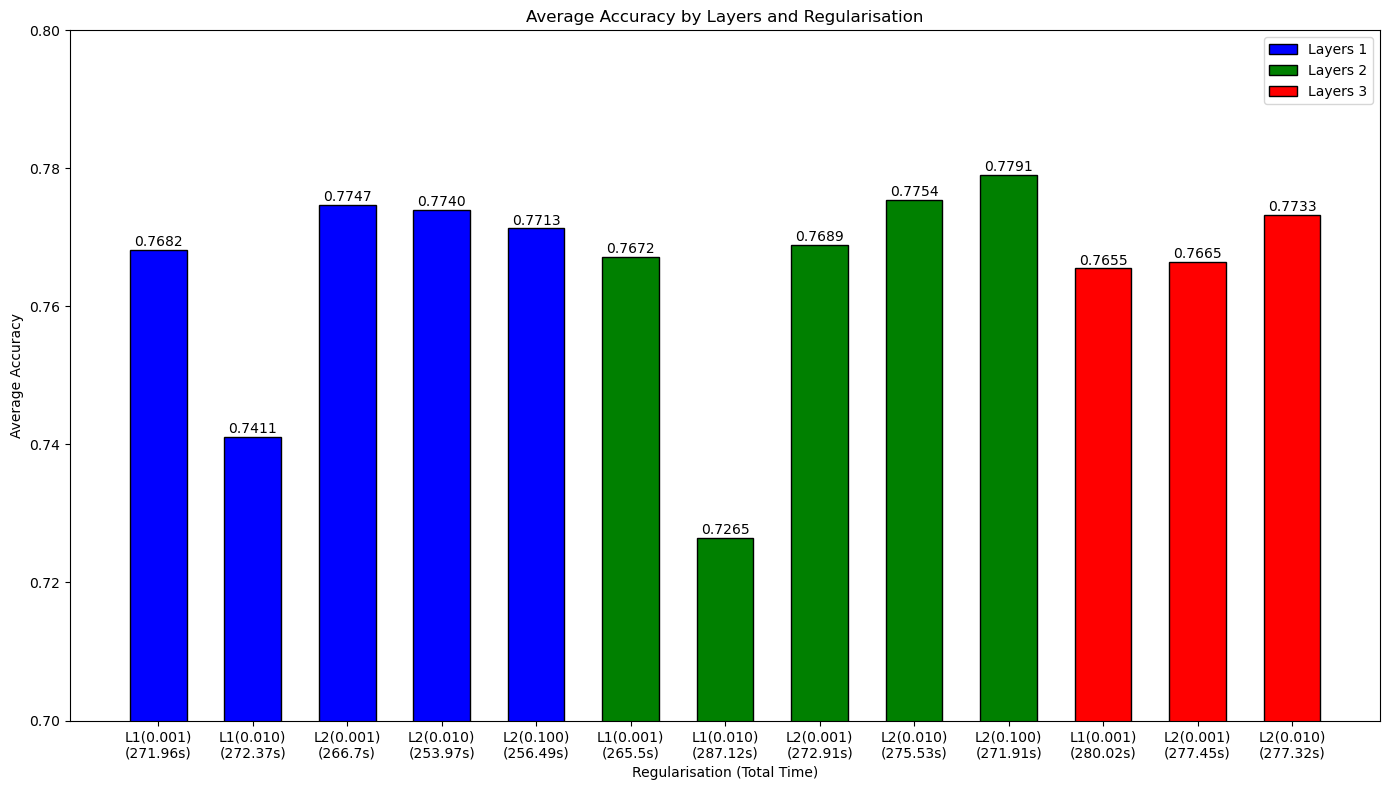

In [72]:
# Filter the summary to include only combinations with an average accuracy above 70%
filtered_summary = final_summary[final_summary['Average_Accuracy'] > 0.70]

# Set up the bar width and colors
bar_width = 0.6
colors = ['blue', 'green', 'red']

# Prepare the data
positions = np.arange(len(filtered_summary))
filtered_summary['Label'] = filtered_summary.apply(lambda row: f"{row['Regulariser']}\n({row['Total_Time']}s)", axis=1)
layer_groups = filtered_summary.groupby('Layers')

# Create the plot
fig, ax = plt.subplots(figsize=(14, 8))

# Plot each layer group
current_pos = 0
for i, (layer, group) in enumerate(layer_groups):
    group_positions = positions[current_pos:current_pos + len(group)]
    ax.bar(group_positions, group['Average_Accuracy'], bar_width, color=colors[i], edgecolor='black', label=f'Layers {layer}')
    for pos, v in zip(group_positions, group['Average_Accuracy']):
        ax.text(pos, v + 0.0001, f'{v:.4f}', ha='center', va='bottom')
    current_pos += len(group)

# Set the y-axis limits
ax.set_ylim(0.70, 0.80)

# Add labels and legend
ax.set_xlabel('Regularisation (Total Time)')
ax.set_ylabel('Average Accuracy')
ax.set_title('Average Accuracy by Layers and Regularisation')
ax.set_xticks(positions)
ax.set_xticklabels(filtered_summary['Label'], rotation=0, ha="center")
ax.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

#### Step 5: Training the model and evaluation

Now, I will train the model twice: once with the baseline hyperparameters and one with the optimal ones.
<br>Baseline:

Epoch 1/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5871 - loss: 2.5999
Epoch 2/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6285 - loss: 1.7003
Epoch 3/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6764 - loss: 1.3860
Epoch 4/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6680 - loss: 1.2021
Epoch 5/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6715 - loss: 1.0596
Epoch 6/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6819 - loss: 1.0064
Epoch 7/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6908 - loss: 0.9480
Epoch 8/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6885 - loss: 0.8812
Epoch 9/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6925 - loss: 0.8436
Epoch 10/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6757 - loss: 0.8336
Epoch 11/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6960 - loss: 0.7991
Epoch 12/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

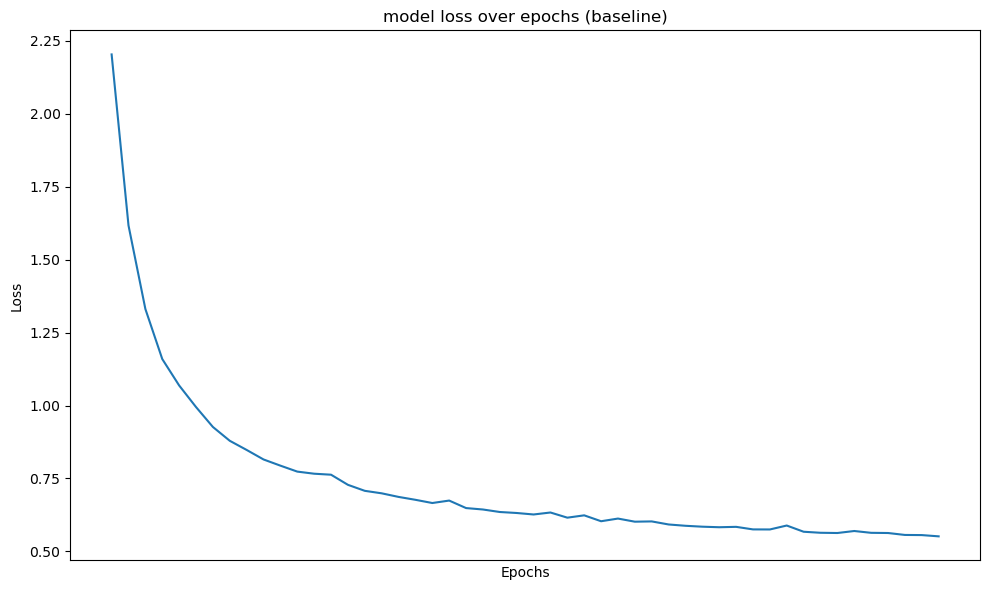

In [81]:
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'  # suppress onednn

df = pd.read_csv('match-data.csv')

# feature engineering
df['blueTeamWardRetentionRatio'] = (df.blueTeamWardsPlaced - df.redTeamWardsDestroyed) / df.blueTeamWardsPlaced
df['blueTeamNetKills'] = (df.blueTeamKills - df.redTeamKills).astype(float)
df['blueTeamJungleMinionsKilledDiff'] = (df.blueTeamTotalJungleMinionsKilled - df.redTeamTotalJungleMinionsKilled)
df['blueTeamMinionsKilledDiff'] = (df.blueTeamTotalMinionsKilled - df.redTeamTotalMinionsKilled)
df['blueTeamAvgLevelDiff'] = (df.blueTeamAvgLevel - df.redTeamAvgLevel)
df['blueTeamCsPerMinuteDiff'] = (df.blueTeamCsPerMinute - df.redTeamCsPerMinute)
df['blueTeamGoldPerMinuteDiff'] = (df.blueTeamGoldPerMinute - df.redTeamGoldPerMinute)

# remove the columns that are not needed
df = df[['winningTeam', 'blueTeamWardRetentionRatio', 'blueTeamNetKills', 'blueTeamJungleMinionsKilledDiff',
         'blueTeamMinionsKilledDiff', 'blueTeamAvgLevelDiff', 'blueTeamCsPerMinuteDiff', 'blueTeamGoldPerMinuteDiff']]

# drop NA
df = df.dropna()

# normalise the data except for the target variable 'winningTeam'
df.iloc[:, 1:] = (df.iloc[:, 1:] - df.iloc[:, 1:].mean()) / df.iloc[:, 1:].std()

# splitting
X = df.drop('winningTeam', axis=1)
y = df['winningTeam']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0)


# timing
m_start = time.time()

# create the model
model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(32, activation='relu', activity_regularizer=L2(0.01)))
model.add(Dense(1, activation='relu'))

# compile & train the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=50, batch_size=20)

# evaluate by accuracy
_, accuracy = model.evaluate(X_test, y_test, verbose=0)
print('Accuracy: %.2f' % (accuracy * 100), f'duration: {round(time.time() - m_start, 2)}s\n')

# plot the loss after the third iteration
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.title('model loss over epochs (baseline)')
plt.ylabel('Loss')
plt.xticks([])
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

You can see that the loss steadily drops after the first couple of epochs, and stabilizes after.
<br>
<br>Below is the classification report for this model:

In [76]:
# Get the model's predictions
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary values

# Print the classification report
print("Accuracy Report:")
print(classification_report(y_test, y_pred))


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Accuracy Report:
              precision    recall  f1-score   support

           0       0.82      0.68      0.74       229
           1       0.68      0.82      0.74       192

    accuracy                           0.74       421
   macro avg       0.75      0.75      0.74       421
weighted avg       0.75      0.74      0.74       421



Now, we plot a ROC-curve. 
<br>The ROC (Receiver Operating Characteristic) curve shows how well the model distinguishes between two classes across different thresholds. It plots the True Positive Rate (TPR) against the False Positive Rate (FPR).

The AUC (Area Under the Curve) score summarizes the ROC curve as a single number:

- AUC = 1.0: Perfect model.
- AUC = 0.5: Random guessing.
- AUC > 0.7: Indicates a good model.

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


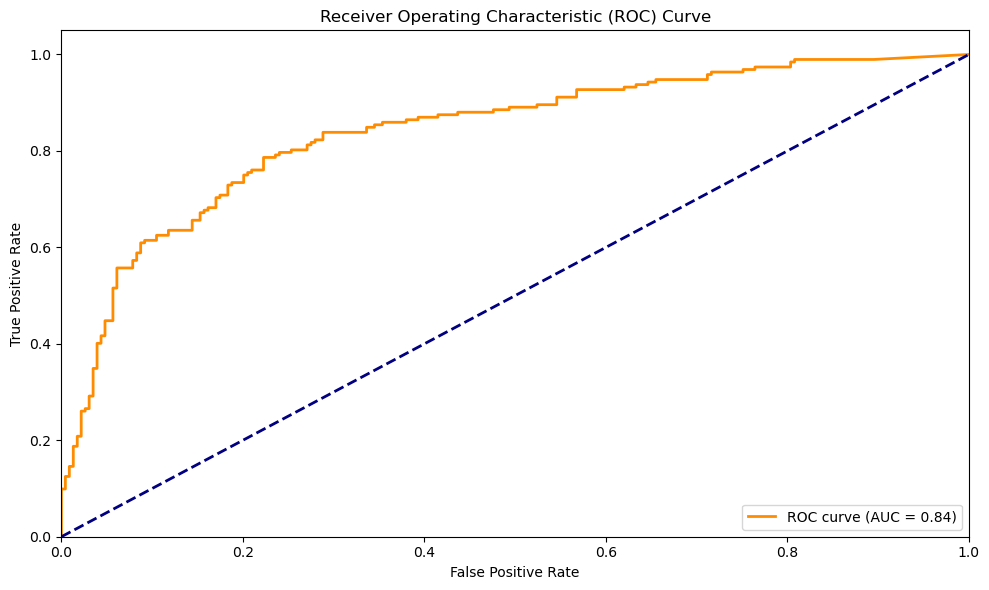

In [82]:
# Get predicted probabilities for the positive class
y_pred_prob = model.predict(X_test).ravel()  # Flatten the array if needed

# Calculate the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

# Calculate the AUC score
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

The AOC is 0.84, which means that the model is performing well.

Now, we train the model with optimized hyperparameters:

Epoch 1/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5590 - loss: 17.3104
Epoch 2/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6940 - loss: 14.9794
Epoch 3/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6851 - loss: 13.0831
Epoch 4/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6759 - loss: 11.5047
Epoch 5/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5838 - loss: 10.1310
Epoch 6/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6680 - loss: 8.9846
Epoch 7/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6470 - loss: 7.9858
Epoch 8/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6103 - loss: 7.1244
Epoch 9/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7043 - loss: 6.3951
Epoch 10/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6713 - loss: 5.7449
Epoch 11/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6387 - loss: 5.1951
Epoch 12/150
120/120 ━━━━━━━━━━━━━━━

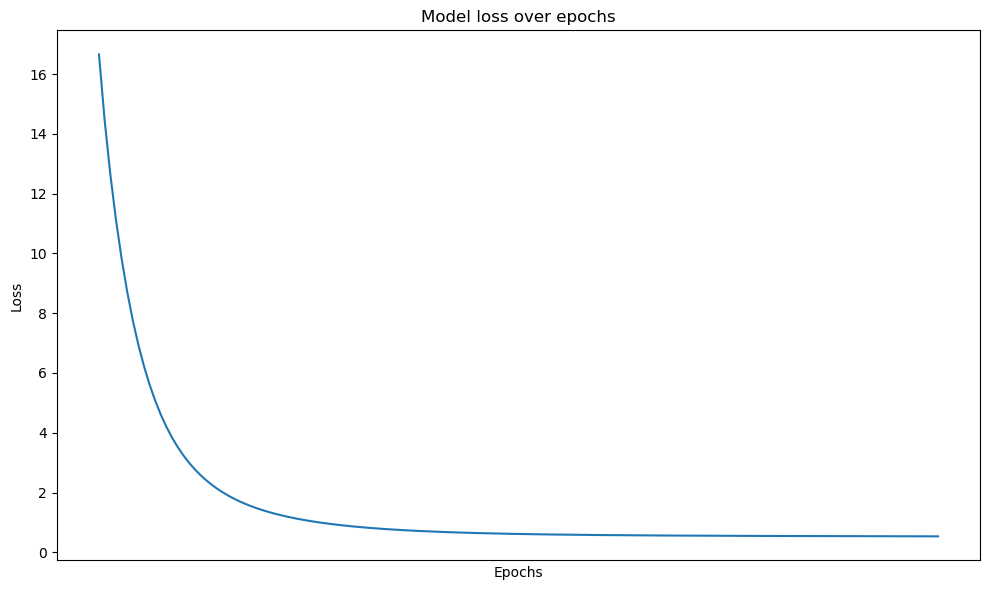

In [83]:
# Start time to measure training duration
m_start = time.time()

# Create the model with the updated hyperparameters
model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(32, activation='sigmoid', activity_regularizer=L2(0.1)))  # Updated activation and regularizer
model.add(Dense(1, activation='sigmoid'))  # Output layer updated to sigmoid for binary classification

# Compile the model with updated settings
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model with updated epochs and batch size
history = model.fit(X_train, y_train, epochs=150, batch_size=20)  # Updated epochs to 150

# Evaluate the model and print accuracy
_, accuracy = model.evaluate(X_test, y_test, verbose=0)
print('Accuracy: %.2f' % (accuracy * 100), f'duration: {round(time.time() - m_start, 2)}s\n')

# Plot the loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.title('Model loss over epochs')
plt.ylabel('Loss')
plt.xticks([])
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

In [78]:
# Get the model's predictions
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary values

# Print the classification report
print("Accuracy Report:")
print(classification_report(y_test, y_pred))

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Accuracy Report:
              precision    recall  f1-score   support

           0       0.83      0.71      0.77       229
           1       0.71      0.83      0.76       192

    accuracy                           0.76       421
   macro avg       0.77      0.77      0.76       421
weighted avg       0.77      0.76      0.77       421



14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


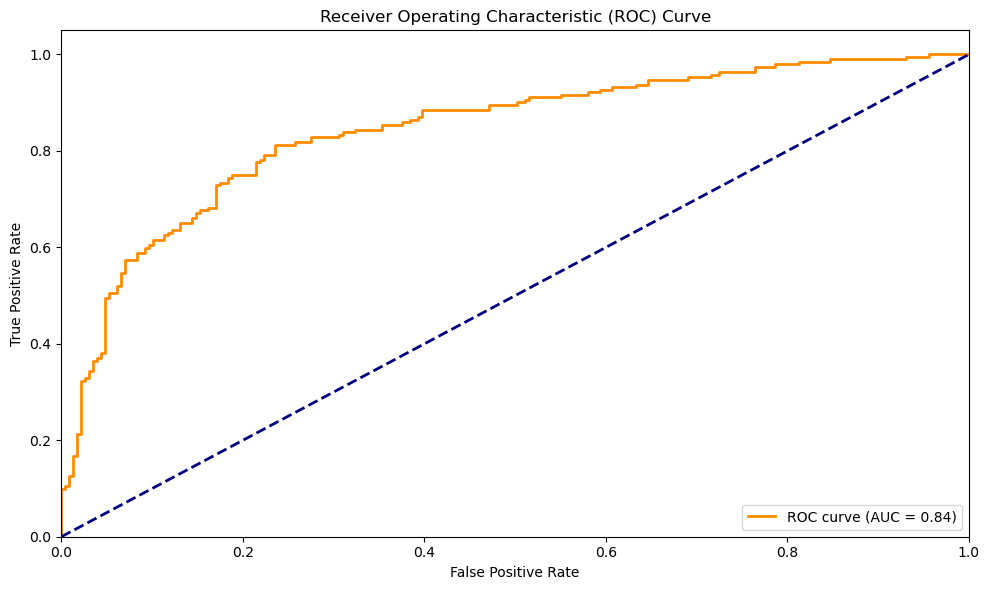

In [84]:
# Get predicted probabilities for the positive class
y_pred_prob = model.predict(X_test).ravel()  # Flatten the array if needed

# Calculate the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

# Calculate the AUC score
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

The baseline model is already fairly accurate, and optimizing the hyperparameters makes it perform even better. Since the aim was between 70% and 80% accuracy, these results are really acceptable. 

#### End of notebook
